# Stock/Index Prediction with Transformers

In this notebook, stock/index prediction is performed using data extracted from Yahoo Finance, different features used in finance are created, and a Transformer-based network is trained and tested.

In [1]:
#We import necessary libraries
import yfinance as yf
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import torchmetrics
from torch.utils.data import DataLoader, TensorDataset
import math
from utils.functions import *
import optuna


We imported the data from yahoo finance

In [2]:
#We downloaded the data using yahoo finance
#start_date = dt.datetime(2022, 1, 1)
start_date = dt.datetime(2019, 1, 1)
end_date = dt.datetime(2024, 1, 1)# dt.datetime.now()


# Energy Stocks
energy_stocks = ['ENPH', 'FSLR', 'SHEL','XOM', 'CVX','BP', 'TTE', 'NEE', 'DUK', ] #
stock_data = {stock: get_data(stock, start_date, end_date) for stock in energy_stocks}

# Energy Indices
energy_indices = ['^GSPE', 'ICLN']
index_data = {index: get_data(index, start_date, end_date) for index in energy_indices}


index_data = pd.DataFrame.from_dict(index_data)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


## Feature engineering
In addition to the stock, we include variables typically used in finance.
Note that these new features have been obtained causally, so there is no data leakage.

In [3]:
df_data = pd.DataFrame.from_dict(stock_data)
df_data = pd.concat([df_data, index_data],axis=1)


#Simple Moving Average 
df_sma_5 = compute_sma(df_data, 5)
df_sma_20 = compute_sma(df_data, 20)
# Exponential Moving Average
df_ema_5 = compute_ema(df_data, 5)
 #Relative Strength Index 
df_rsi_14 = compute_rsi(df_data, 14)
#Moving Average Convergence Divergence 
df_macd, df_macd_signal = compute_macd(df_data)
#Volatility (Standard Deviation or Bollinger Bands)
df_bb_upper, df_bb_lower = compute_bollinger_bands(df_data, 20)

df_data[df_sma_5.columns] = df_sma_5
df_data[df_sma_20.columns] = df_sma_20
df_data[df_ema_5.columns] = df_ema_5
df_data[df_rsi_14.columns] = df_rsi_14
df_data[df_macd.columns] = df_macd
df_data[df_macd_signal.columns] = df_macd_signal
df_data[df_bb_upper.columns] = df_bb_upper
df_data[df_bb_lower.columns] = df_bb_lower


df_dates = add_date_features(df_data) 

df_data[df_dates.columns] = df_dates

df_data.dropna(axis=0, inplace=True)


/tmp/ipykernel_175052/3185020324.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_data[df_dates.columns] = df_dates
/tmp/ipykernel_175052/3185020324.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_data[df_dates.columns] = df_dates
/tmp/ipykernel_175052/3185020324.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, u

Below we visualize these new features, in particular the new features for the 'ICLN' target are graphed. Note that the graphs are for the same variable, but due to the scale of the different features, a subplot has been made.

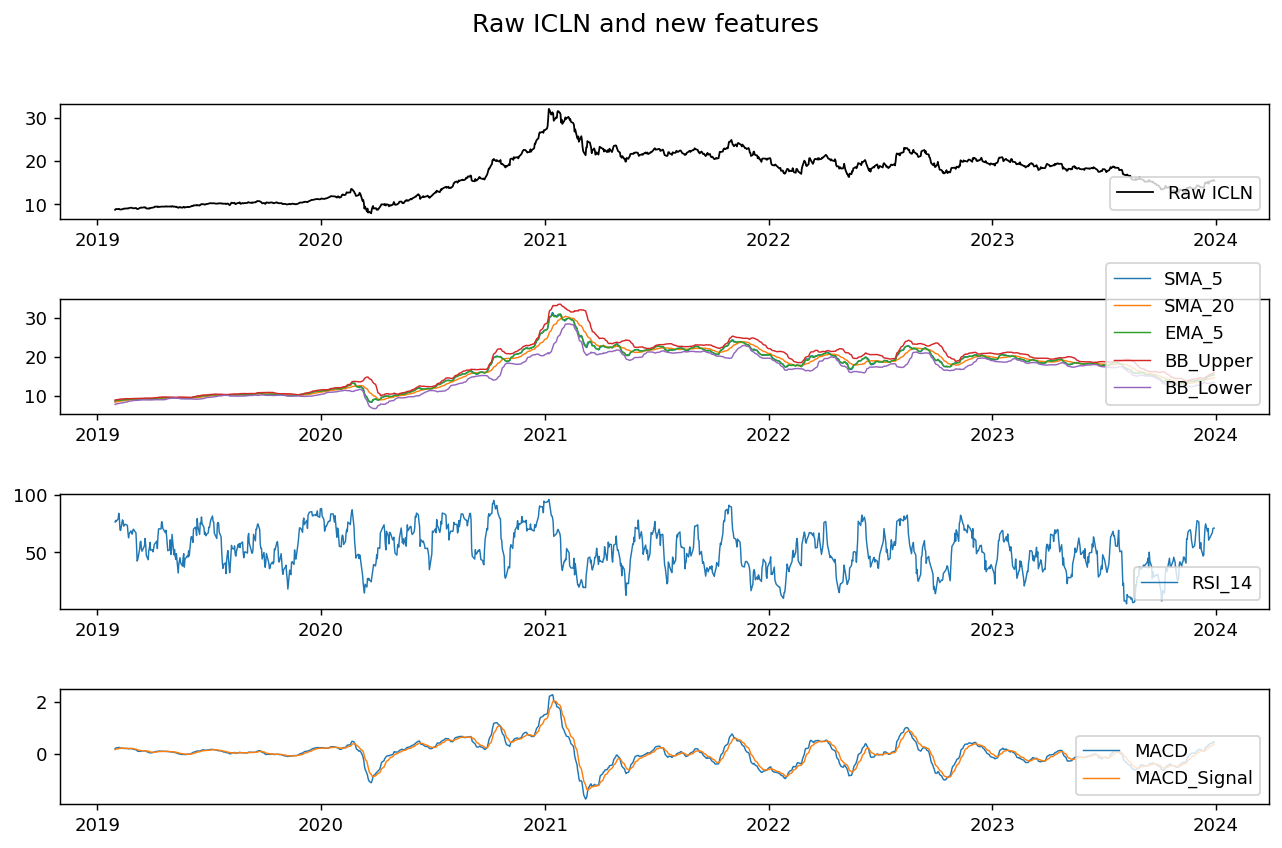

In [4]:
name_target ='ICLN'

fig, ax = plt.subplots(nrows=4,figsize=(12, 7), dpi=130)
plt.suptitle('Raw '+name_target+' and new features', size=14)
ax[0].plot(df_data[name_target], label ='Raw '+name_target, color= 'k',linewidth=1)
ax[1].plot(df_data[name_target+'_SMA_5'], label ='SMA_5', linewidth=0.8)
ax[1].plot(df_data[name_target+'_SMA_20'], label ='SMA_20', linewidth=0.8)
ax[1].plot(df_data[name_target+'_EMA_5'], label ='EMA_5', linewidth=0.8)
ax[1].plot(df_data[name_target+'_BB_Upper'], label ='BB_Upper', linewidth=0.8)
ax[1].plot(df_data[name_target+'_BB_Lower'], label ='BB_Lower', linewidth=0.8)


ax[2].plot(df_data[name_target+'_RSI_14'], label ='RSI_14', linewidth=0.8)
ax[3].plot(df_data[name_target+'_MACD'], label ='MACD', linewidth=0.8)
ax[3].plot(df_data[name_target+'_MACD_Signal'], label ='MACD_Signal', linewidth=0.8)


ax[0].legend(loc=4)
ax[1].legend(loc=4)
ax[2].legend(loc=4)
ax[3].legend(loc=4)
plt.subplots_adjust(hspace=0.7,)

plt.show()

We divide the database into train, validation and test

In [5]:
split_idx_train = int(len(df_data) * 0.6)
split_idx_val = int(len(df_data) * 0.2)


train_df = df_data[:split_idx_train]
val_df = df_data[split_idx_train:split_idx_train + split_idx_val]
test_df = df_data[split_idx_train + split_idx_val:]


print('date range train: {} - {} '.format(train_df.index[0],train_df.index[-1]))
print('date range val: {} - {} '.format(val_df.index[0],val_df.index[-1]))
print('date range test: {} - {} '.format(test_df.index[0],test_df.index[-1]))



date range train: 2019-01-30 00:00:00 - 2022-01-07 00:00:00 
date range val: 2022-01-10 00:00:00 - 2023-01-03 00:00:00 
date range test: 2023-01-04 00:00:00 - 2023-12-29 00:00:00 


We decide which features and target we want to use in the model

In [6]:
#Define the target and features to use
name_target ='ICLN' #
name_features = train_df.columns.to_list() # [ 'TTE ,'ENPH', 'FSLR', 'SHEL' ]#


## Hyperparameters optimisation using Optuna
In the file functions.py, which is imported at the start, we define the Transformer model to be trained. Achieving good results depends heavily on optimising the hyperparameters. In our case, we will use the Optuna library to efficiently search for the optimal parameters for our task.

In [7]:

def objective(trial):

    window_size = trial.suggest_int('window_size', 5, 60) 
    name_scale = trial.suggest_categorical('scaling_method', ['MinMax', 'StandardScaler'])
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128])

    #Preprocessing
    train_X, train_y, info_dates_train, scaler, idx_target = preprocess_data(train_df, name_target, name_features, window_size, scaler=name_scale)
    val_X, val_y, info_dates_val, _, _ = preprocess_data(val_df, name_target, name_features, window_size, scaler)

    #DataTensor
    train_X_tensor, train_y_tensor = torch.tensor(train_X, dtype=torch.float32), torch.tensor(train_y, dtype=torch.float32)
    val_X_tensor, val_y_tensor = torch.tensor(val_X, dtype=torch.float32), torch.tensor(val_y, dtype=torch.float32)

    #Dataloader
    train_loader = DataLoader(TensorDataset(train_X_tensor, train_y_tensor), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(TensorDataset(val_X_tensor, val_y_tensor), batch_size=batch_size)

    input_size = train_X.shape[-1]
    trial.set_user_attr('input_size', input_size)


    # Define hyperparameters to optimise
    d_model =  trial.suggest_categorical('d_model', [32, 64, 128, 256]) 
    num_layers = trial.suggest_int('num_layers', 1, 8) 
    nhead = trial.suggest_categorical('nhead', [2, 4, 8, 16]) 
    max_len = trial.suggest_int('max_len', 100, 500) 
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)


    model = modelTransformer(num_layers=num_layers, d_model=d_model, nhead=nhead, input_size=input_size, max_len=max_len)

    loss_function = nn.MSELoss()
    optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, mode='min', factor=0.1, patience=10)
    early_stopping = EarlyStopping(patience=10, min_delta=0.0001)

    
    metrics = {'loss_train': [], 'loss_val': [],
                'mape_train':[], 'mape_val':[],
               'rmse_train':[], 'rmse_val':[]}
    mape_metric = torchmetrics.MeanAbsolutePercentageError()
    rmse_metric = torchmetrics.MeanSquaredError(squared=False)  
    epochs = 100
    trial.set_user_attr('epochs', epochs)

    for epoch in range(epochs):
       
        mape_metric.reset()
        rmse_metric.reset()

        model.train()
        train_loss, train_mape, train_rmse = 0, 0, 0
        for X_batch, y_batch in train_loader:
            optimiser.zero_grad()
            y_pred = model(X_batch)  
                  
            loss = loss_function(y_pred, y_batch)
            loss.backward()
            optimiser.step()
            train_loss += loss.item()
            train_mape += mape_metric(y_pred, y_batch).item() 
            train_rmse += rmse_metric(y_pred, y_batch).item() 

        train_loss /= len(train_loader)
        train_mape /= len(train_loader)
        train_rmse /= len(train_loader)

        metrics['loss_train'].append(train_loss)
        metrics['mape_train'].append(train_mape)
        metrics['rmse_train'].append(train_rmse)


        model.eval()
        val_loss, val_mape, val_rmse = 0, 0, 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                y_pred = model(X_batch) 
                loss = loss_function(y_pred, y_batch)
                val_loss += loss.item()

                val_mape += mape_metric(y_pred, y_batch).item() 
                val_rmse += rmse_metric(y_pred, y_batch).item() 


        val_loss /= len(val_loader)
        val_mape /= len(val_loader)
        val_rmse /= len(val_loader)


        metrics['loss_val'].append(val_loss)
        metrics['mape_val'].append(val_mape)
        metrics['rmse_val'].append(val_rmse)

        scheduler.step(val_loss)
        trial.report(val_loss, epoch)
        
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
        
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print(f"Early stopping triggered at epoch {epoch}")
            break

        if epoch % 10 == 0:
            print(f'Epoch {epoch+1}/{epochs}:')
            print(f'  Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
            print(f'  Train MAPE: {train_mape:.2f}%, Validation MAPE: {val_mape:.2f}%')
            print(f'  Train RMSE: {train_rmse:.4f}, Validation RMSE: {val_rmse:.4f}')


    return val_loss





In [8]:
#Create and run the Optuna study, minimise the val loss
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler()) #Tree-structured Parzen Estimator
study.optimize(objective, n_trials=20)

[I 2024-10-18 17:21:35,628] A new study created in memory with name: no-name-8156b884-7d63-432b-8d3a-a922c1661e05
/home/mam123/anaconda3/envs/QML_env/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1/100:
  Train Loss: 2.0241, Validation Loss: 0.1725
  Train MAPE: 12.85%, Validation MAPE: 0.60%
  Train RMSE: 1.2217, Validation RMSE: 0.3888
Epoch 11/100:
  Train Loss: 0.9875, Validation Loss: 0.3693
  Train MAPE: 1.34%, Validation MAPE: 0.99%
  Train RMSE: 0.9909, Validation RMSE: 0.5883


[I 2024-10-18 17:25:11,245] Trial 0 finished with value: 0.2740836764375369 and parameters: {'window_size': 59, 'scaling_method': 'StandardScaler', 'batch_size': 32, 'd_model': 128, 'num_layers': 8, 'nhead': 16, 'max_len': 248, 'learning_rate': 0.0013560655054062035}. Best is trial 0 with value: 0.2740836764375369.


Early stopping triggered at epoch 15


/home/mam123/anaconda3/envs/QML_env/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1/100:
  Train Loss: 3.8350, Validation Loss: 0.0072
  Train MAPE: 826.49%, Validation MAPE: 0.13%
  Train RMSE: 1.1505, Validation RMSE: 0.0787
Epoch 11/100:
  Train Loss: 0.0689, Validation Loss: 0.0125
  Train MAPE: 430.85%, Validation MAPE: 0.18%
  Train RMSE: 0.2615, Validation RMSE: 0.1061


[I 2024-10-18 17:28:02,972] Trial 1 finished with value: 0.023241075687110424 and parameters: {'window_size': 60, 'scaling_method': 'MinMax', 'batch_size': 64, 'd_model': 128, 'num_layers': 8, 'nhead': 8, 'max_len': 207, 'learning_rate': 0.007279140582739785}. Best is trial 1 with value: 0.023241075687110424.


Early stopping triggered at epoch 13


/home/mam123/anaconda3/envs/QML_env/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1/100:
  Train Loss: 8.3980, Validation Loss: 1.1549
  Train MAPE: 20.61%, Validation MAPE: 2.06%
  Train RMSE: 2.2395, Validation RMSE: 1.0729
Epoch 11/100:
  Train Loss: 0.9842, Validation Loss: 0.2333
  Train MAPE: 1.21%, Validation MAPE: 0.73%
  Train RMSE: 0.9904, Validation RMSE: 0.4788


[I 2024-10-18 17:30:55,880] Trial 2 finished with value: 0.4026620462536812 and parameters: {'window_size': 39, 'scaling_method': 'StandardScaler', 'batch_size': 64, 'd_model': 256, 'num_layers': 8, 'nhead': 16, 'max_len': 453, 'learning_rate': 0.006512202443379803}. Best is trial 1 with value: 0.023241075687110424.


Early stopping triggered at epoch 11


/home/mam123/anaconda3/envs/QML_env/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1/100:
  Train Loss: 0.2059, Validation Loss: 0.0336
  Train MAPE: 0.81%, Validation MAPE: 0.37%
  Train RMSE: 0.3841, Validation RMSE: 0.1728


[I 2024-10-18 17:31:10,387] Trial 3 finished with value: 0.10828751114507516 and parameters: {'window_size': 20, 'scaling_method': 'StandardScaler', 'batch_size': 16, 'd_model': 256, 'num_layers': 1, 'nhead': 4, 'max_len': 203, 'learning_rate': 3.366323125977254e-05}. Best is trial 1 with value: 0.023241075687110424.


Early stopping triggered at epoch 10


/home/mam123/anaconda3/envs/QML_env/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1/100:
  Train Loss: 2.2527, Validation Loss: 0.1348
  Train MAPE: 2.85%, Validation MAPE: 0.53%
  Train RMSE: 1.2968, Validation RMSE: 0.3423


[I 2024-10-18 17:31:38,333] Trial 4 finished with value: 0.696025550365448 and parameters: {'window_size': 25, 'scaling_method': 'StandardScaler', 'batch_size': 32, 'd_model': 64, 'num_layers': 2, 'nhead': 2, 'max_len': 487, 'learning_rate': 0.06991193351964411}. Best is trial 1 with value: 0.023241075687110424.


Early stopping triggered at epoch 10


/home/mam123/anaconda3/envs/QML_env/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-18 17:31:39,838] Trial 5 pruned. 
/home/mam123/anaconda3/envs/QML_env/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1/100:
  Train Loss: 2.1645, Validation Loss: 0.0628
  Train MAPE: 770.70%, Validation MAPE: 0.50%
  Train RMSE: 0.9995, Validation RMSE: 0.2488
Epoch 11/100:
  Train Loss: 0.0729, Validation Loss: 0.0120
  Train MAPE: 312.90%, Validation MAPE: 0.19%
  Train RMSE: 0.2692, Validation RMSE: 0.1052
Epoch 21/100:
  Train Loss: 0.0718, Validation Loss: 0.0122
  Train MAPE: 439.02%, Validation MAPE: 0.19%
  Train RMSE: 0.2678, Validation RMSE: 0.1061


[I 2024-10-18 17:35:58,013] Trial 6 finished with value: 0.02026693453080952 and parameters: {'window_size': 50, 'scaling_method': 'MinMax', 'batch_size': 64, 'd_model': 128, 'num_layers': 8, 'nhead': 4, 'max_len': 338, 'learning_rate': 0.0009459678692541384}. Best is trial 6 with value: 0.02026693453080952.


Early stopping triggered at epoch 25


/home/mam123/anaconda3/envs/QML_env/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-18 17:36:02,493] Trial 7 pruned. 
/home/mam123/anaconda3/envs/QML_env/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-18 17:36:03,945] Trial 8 pruned. 
/home/mam123/anaconda3/envs/QML_env/lib/python3.12/site-packages/torch/nn/modules/transf

Epoch 1/100:
  Train Loss: 0.0479, Validation Loss: 0.0525
  Train MAPE: 338.74%, Validation MAPE: 0.43%
  Train RMSE: 0.2181, Validation RMSE: 0.2277
Epoch 11/100:
  Train Loss: 0.0130, Validation Loss: 0.0149
  Train MAPE: 102.02%, Validation MAPE: 0.21%
  Train RMSE: 0.1135, Validation RMSE: 0.1174


[I 2024-10-18 17:36:12,969] Trial 9 finished with value: 0.01357403863221407 and parameters: {'window_size': 27, 'scaling_method': 'MinMax', 'batch_size': 128, 'd_model': 128, 'num_layers': 1, 'nhead': 16, 'max_len': 367, 'learning_rate': 2.4449387276367407e-05}. Best is trial 9 with value: 0.01357403863221407.


Early stopping triggered at epoch 11


/home/mam123/anaconda3/envs/QML_env/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1/100:
  Train Loss: 0.1049, Validation Loss: 0.0068
  Train MAPE: 59.63%, Validation MAPE: 0.13%
  Train RMSE: 0.3230, Validation RMSE: 0.0806


[I 2024-10-18 17:36:18,678] Trial 10 finished with value: 0.10604961588978767 and parameters: {'window_size': 7, 'scaling_method': 'MinMax', 'batch_size': 128, 'd_model': 32, 'num_layers': 5, 'nhead': 2, 'max_len': 115, 'learning_rate': 1.0808624093504806e-05}. Best is trial 9 with value: 0.01357403863221407.


Early stopping triggered at epoch 10


/home/mam123/anaconda3/envs/QML_env/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-18 17:36:23,952] Trial 11 pruned. 
/home/mam123/anaconda3/envs/QML_env/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-18 17:36:27,880] Trial 12 pruned. 
/home/mam123/anaconda3/envs/QML_env/lib/python3.12/site-packages/torch/nn/modules/tran

Epoch 1/100:
  Train Loss: 0.2040, Validation Loss: 0.0240
  Train MAPE: 163.72%, Validation MAPE: 0.27%
  Train RMSE: 0.4373, Validation RMSE: 0.1448
Epoch 11/100:
  Train Loss: 0.0152, Validation Loss: 0.0040
  Train MAPE: 216.17%, Validation MAPE: 0.11%
  Train RMSE: 0.1211, Validation RMSE: 0.0596


[I 2024-10-18 17:37:31,120] Trial 16 finished with value: 0.004087914355165724 and parameters: {'window_size': 42, 'scaling_method': 'MinMax', 'batch_size': 32, 'd_model': 64, 'num_layers': 4, 'nhead': 4, 'max_len': 312, 'learning_rate': 1.3205313064071174e-05}. Best is trial 16 with value: 0.004087914355165724.


Early stopping triggered at epoch 16


/home/mam123/anaconda3/envs/QML_env/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-18 17:37:33,900] Trial 17 pruned. 
/home/mam123/anaconda3/envs/QML_env/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1/100:
  Train Loss: 0.0590, Validation Loss: 0.0068
  Train MAPE: 938.82%, Validation MAPE: 0.15%
  Train RMSE: 0.2313, Validation RMSE: 0.0778
Epoch 11/100:
  Train Loss: 0.0057, Validation Loss: 0.0110
  Train MAPE: 109.85%, Validation MAPE: 0.19%
  Train RMSE: 0.0751, Validation RMSE: 0.1000
Epoch 21/100:
  Train Loss: 0.0033, Validation Loss: 0.0102
  Train MAPE: 9.18%, Validation MAPE: 0.19%
  Train RMSE: 0.0570, Validation RMSE: 0.0982


[I 2024-10-18 17:38:12,441] Trial 18 finished with value: 0.008322412347687142 and parameters: {'window_size': 29, 'scaling_method': 'MinMax', 'batch_size': 32, 'd_model': 64, 'num_layers': 3, 'nhead': 16, 'max_len': 404, 'learning_rate': 4.047449127182763e-05}. Best is trial 16 with value: 0.004087914355165724.


Early stopping triggered at epoch 22


/home/mam123/anaconda3/envs/QML_env/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1/100:
  Train Loss: 0.0850, Validation Loss: 0.0112
  Train MAPE: 12.64%, Validation MAPE: 0.20%
  Train RMSE: 0.2781, Validation RMSE: 0.0980
Epoch 11/100:
  Train Loss: 0.0059, Validation Loss: 0.0044
  Train MAPE: 20.36%, Validation MAPE: 0.12%
  Train RMSE: 0.0759, Validation RMSE: 0.0617
Epoch 21/100:
  Train Loss: 0.0037, Validation Loss: 0.0030
  Train MAPE: 92.96%, Validation MAPE: 0.09%
  Train RMSE: 0.0601, Validation RMSE: 0.0487
Epoch 31/100:
  Train Loss: 0.0029, Validation Loss: 0.0035
  Train MAPE: 2.38%, Validation MAPE: 0.09%
  Train RMSE: 0.0528, Validation RMSE: 0.0524


[I 2024-10-18 17:39:29,307] Trial 19 finished with value: 0.002127301488404295 and parameters: {'window_size': 42, 'scaling_method': 'MinMax', 'batch_size': 32, 'd_model': 64, 'num_layers': 3, 'nhead': 4, 'max_len': 409, 'learning_rate': 6.353324174187384e-05}. Best is trial 19 with value: 0.002127301488404295.


Early stopping triggered at epoch 34


## Training the best model
After completing the hyperparameter optimisation, we select the best model, retrain it with the optimal hyperparameters (this step can be skipped if the model is saved), and then evaluate it on the test set

In [9]:
best_params = study.best_params
print("Best hyperparameters:", best_params)

window_size = study.best_params['window_size']
name_scale = study.best_params['scaling_method']

#Preprocessing
train_X, train_y, info_dates_train, scaler, idx_target = preprocess_data(train_df, name_target, name_features, window_size, scaler=name_scale)
val_X, val_y, info_dates_val, _, _ = preprocess_data(val_df, name_target, name_features, window_size, scaler)
test_X, test_y, info_dates_test, _, _ = preprocess_data(test_df, name_target, name_features, window_size, scaler)

#DataTensor
train_X_tensor, train_y_tensor = torch.tensor(train_X, dtype=torch.float32), torch.tensor(train_y, dtype=torch.float32)
val_X_tensor, val_y_tensor = torch.tensor(val_X, dtype=torch.float32), torch.tensor(val_y, dtype=torch.float32)
test_X_tensor, test_y_tensor = torch.tensor(test_X, dtype=torch.float32), torch.tensor(test_y, dtype=torch.float32)

#Dataloader
train_loader = DataLoader(TensorDataset(train_X_tensor, train_y_tensor), batch_size=best_params['batch_size'], shuffle=True)
val_loader = DataLoader(TensorDataset(val_X_tensor, val_y_tensor), batch_size=best_params['batch_size'])
test_loader = DataLoader(TensorDataset(test_X_tensor, test_y_tensor), batch_size=best_params['batch_size'])


input_size = study.best_trial.user_attrs['input_size']

best_model = modelTransformer(num_layers=best_params['num_layers'], d_model=best_params['d_model'],
                               nhead=best_params['nhead'], input_size=input_size,
                               max_len=best_params['max_len'])


loss_function = nn.MSELoss()
optimiser = torch.optim.Adam(best_model.parameters(), lr=best_params['learning_rate'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, mode='min', factor=0.1, patience=10)
early_stopping = EarlyStopping(patience=20, min_delta=0.00001)


metrics = {'loss_train': [], 'loss_val': [],
            'mape_train':[], 'mape_val':[],
            'rmse_train':[], 'rmse_val':[]}

mape_metric = torchmetrics.MeanAbsolutePercentageError()
rmse_metric = torchmetrics.MeanSquaredError(squared=False)  

epochs = study.best_trial.user_attrs['epochs']
for epoch in range(epochs):
    
    mape_metric.reset()
    rmse_metric.reset()

    best_model.train()
    train_loss, train_mape, train_rmse = 0, 0, 0
    for X_batch, y_batch in train_loader:
        optimiser.zero_grad()
        y_pred = best_model(X_batch)  
                
        loss = loss_function(y_pred, y_batch)
        loss.backward()
        optimiser.step()
        train_loss += loss.item()
        train_mape += mape_metric(y_pred, y_batch).item() 
        train_rmse += rmse_metric(y_pred, y_batch).item() 

    train_loss /= len(train_loader)
    train_mape /= len(train_loader)
    train_rmse /= len(train_loader)

    metrics['loss_train'].append(train_loss)
    metrics['mape_train'].append(train_mape)
    metrics['rmse_train'].append(train_rmse)



    best_model.eval()
    val_loss, val_mape, val_rmse = 0, 0, 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            y_pred = best_model(X_batch) 
            loss = loss_function(y_pred, y_batch)
            val_loss += loss.item()

            val_mape += mape_metric(y_pred, y_batch).item() 
            val_rmse += rmse_metric(y_pred, y_batch).item() 


    val_loss /= len(val_loader)
    val_mape /= len(val_loader)
    val_rmse /= len(val_loader)


    metrics['loss_val'].append(val_loss)
    metrics['mape_val'].append(val_mape)
    metrics['rmse_val'].append(val_rmse)

    scheduler.step(val_loss)

    early_stopping(val_loss)
    if early_stopping.early_stop:
        print(f"Early stopping triggered at epoch {epoch}")
        break

    if epoch % 10 == 0:
        print(f'Epoch {epoch+1}/{epochs}:')
        print(f'  Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
        print(f'  Train MAPE: {train_mape:.2f}%, Validation MAPE: {val_mape:.2f}%')
        print(f'  Train RMSE: {train_rmse:.4f}, Validation RMSE: {val_rmse:.4f}')


metrics_best_model = metrics


Best hyperparameters: {'window_size': 42, 'scaling_method': 'MinMax', 'batch_size': 32, 'd_model': 64, 'num_layers': 3, 'nhead': 4, 'max_len': 409, 'learning_rate': 6.353324174187384e-05}


/home/mam123/anaconda3/envs/QML_env/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1/100:
  Train Loss: 0.1764, Validation Loss: 0.0256
  Train MAPE: 850.63%, Validation MAPE: 0.28%
  Train RMSE: 0.3663, Validation RMSE: 0.1442
Epoch 11/100:
  Train Loss: 0.0064, Validation Loss: 0.0085
  Train MAPE: 66.63%, Validation MAPE: 0.17%
  Train RMSE: 0.0794, Validation RMSE: 0.0828
Epoch 21/100:
  Train Loss: 0.0035, Validation Loss: 0.0016
  Train MAPE: 80.92%, Validation MAPE: 0.07%
  Train RMSE: 0.0584, Validation RMSE: 0.0376
Epoch 31/100:
  Train Loss: 0.0025, Validation Loss: 0.0020
  Train MAPE: 47.92%, Validation MAPE: 0.08%
  Train RMSE: 0.0500, Validation RMSE: 0.0426
Epoch 41/100:
  Train Loss: 0.0022, Validation Loss: 0.0024
  Train MAPE: 56.17%, Validation MAPE: 0.09%
  Train RMSE: 0.0463, Validation RMSE: 0.0475
Epoch 51/100:
  Train Loss: 0.0019, Validation Loss: 0.0021
  Train MAPE: 81.35%, Validation MAPE: 0.08%
  Train RMSE: 0.0431, Validation RMSE: 0.0446
Early stopping triggered at epoch 54


In [10]:
#Evaluate

#Real Data
train_real = train_df[name_target][window_size:]
val_real = val_df[name_target][window_size:]
test_real = test_df[name_target][window_size:]

real_combined = pd.concat((train_real, val_real, test_real))


train_pred_scaled = make_predictions(best_model, train_X_tensor)
val_pred_scaled = make_predictions(best_model, val_X_tensor)
test_pred_scaled = make_predictions(best_model, test_X_tensor)



if name_scale == 'Without':

    train_pred_unscaled = train_pred_scaled
    val_pred_unscaled = val_pred_scaled
    test_pred_unscaled = test_pred_scaled

else:
    zeros_shape_scaler = np.zeros((len(train_pred_scaled), len(name_features)))
    zeros_shape_scaler[:,idx_target] = train_pred_scaled
    train_pred_unscaled = scaler.inverse_transform(zeros_shape_scaler)[:,idx_target]

    zeros_shape_scaler = np.zeros((len(val_pred_scaled), len(name_features)))
    zeros_shape_scaler[:,idx_target] = val_pred_scaled
    val_pred_unscaled = scaler.inverse_transform(zeros_shape_scaler)[:,idx_target]


    zeros_shape_scaler = np.zeros((len(test_pred_scaled), len(name_features)))
    zeros_shape_scaler[:,idx_target] = test_pred_scaled
    test_pred_unscaled = scaler.inverse_transform(zeros_shape_scaler)[:,idx_target]



#final metrics:

mape_metric = torchmetrics.MeanAbsolutePercentageError()
rmse_metric = torchmetrics.MeanSquaredError(squared=False)  

metrics_final = {
            'rmse_train': rmse_metric(torch.tensor(train_pred_unscaled), torch.tensor(train_real.values)).item(),
            'mape_train': mape_metric(torch.tensor(train_pred_unscaled), torch.tensor(train_real.values)).item(),
            'rmse_val': rmse_metric(torch.tensor(val_pred_unscaled), torch.tensor(val_real.values)).item(),
            'mape_val': mape_metric(torch.tensor(val_pred_unscaled), torch.tensor(val_real.values)).item(),
            'rmse_test': rmse_metric(torch.tensor(test_pred_unscaled), torch.tensor(test_real.values)).item(),
            'mape_test': mape_metric(torch.tensor(test_pred_unscaled), torch.tensor(test_real.values)).item(),
            
            
            }
ds = pd.Series(metrics_final)
ds.round(3)



rmse_train    0.656
mape_train    0.026
rmse_val      1.083
mape_val      0.047
rmse_test     0.925
mape_test     0.052
dtype: float64

Finally we graph the results, metrics and losses

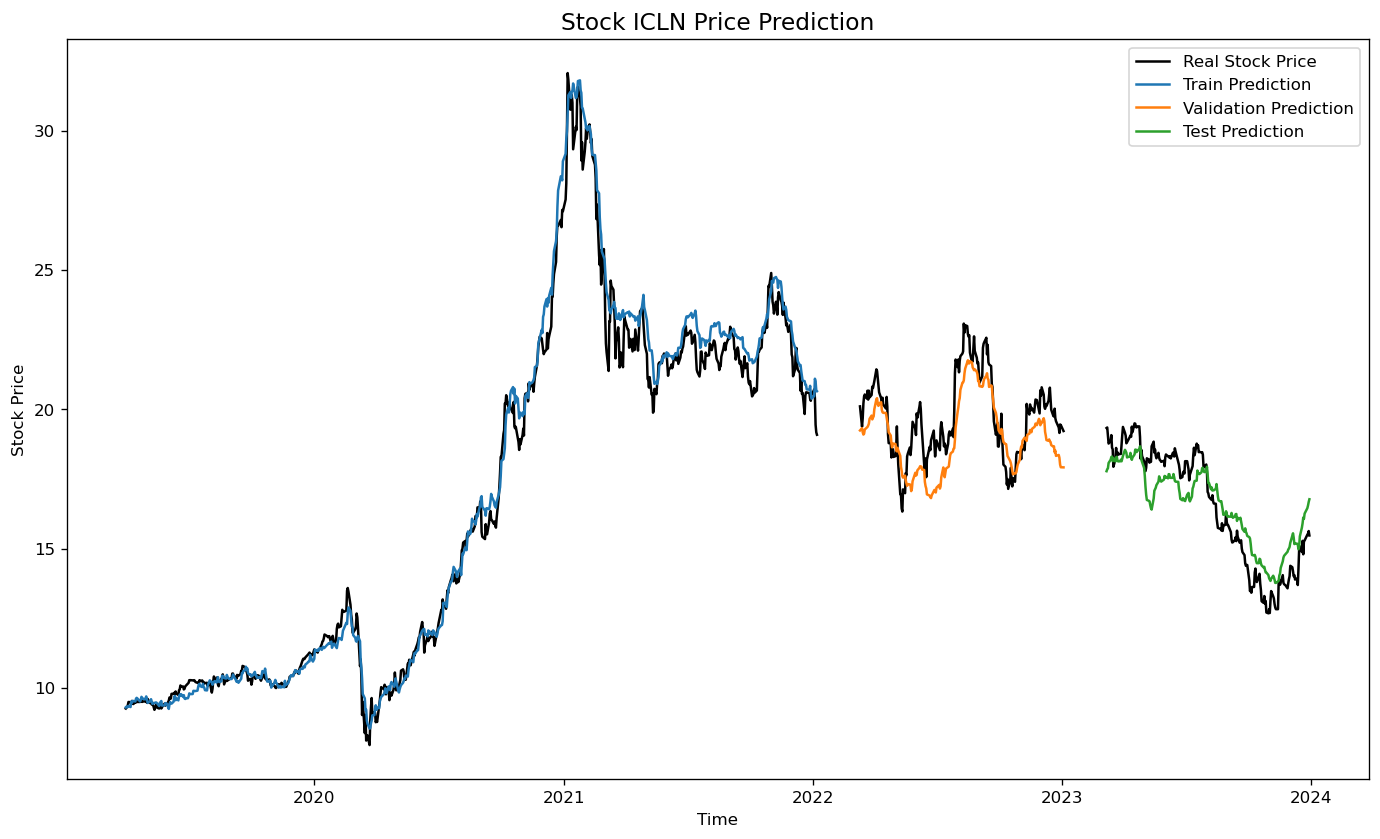

In [11]:
plot_results(real_combined, train_real, val_real, test_real, 
                train_pred_unscaled, val_pred_unscaled, test_pred_unscaled)

## Visualizing results during hyperparameter optimisation

In [12]:
from optuna.visualization import plot_optimization_history, plot_param_importances
from optuna.visualization import plot_contour, plot_slice
import plotly

In [13]:
# Plot optimization history
optimization_history_plot = plot_optimization_history(study)
optimization_history_plot.show()

# Plot parameter importances
param_importances_plot = plot_param_importances(study)
param_importances_plot.show()

# Plot contour of parameters
#contour_plot = plot_contour(study, params=['learning_rate', 'n_layers'])
#contour_plot.show()

# Plot slice of parameters
slice_plot = plot_slice(study, params=['learning_rate', 'num_layers', 'nhead'])
slice_plot.show()

In [14]:
import plotly.graph_objs as go

fig = go.Figure()
fig.add_trace(go.Scatter(y=metrics_best_model['loss_train'], mode='lines', name='Train Loss'))
fig.add_trace(go.Scatter(y=metrics_best_model['loss_val'], mode='lines', name='Validation Loss'))
fig.update_layout(title='Training and Validation Loss | Best Model', xaxis_title='Epoch', yaxis_title='Loss')
fig.update_yaxes(type="log")
fig.show()

# Plot MMSE for each trial
rmse_values = [np.sqrt(trial.value) for trial in study.trials if trial.value is not None]
fig = go.Figure(data=go.Scatter(y=rmse_values, mode='markers'))
fig.update_layout(title='MSE for Each Trial', xaxis_title='Trial', yaxis_title='MSE')
fig.show()